In [1]:
from pyedflib import highlevel
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.signal import spectrogram

In [2]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  
a = torch.zeros(4,3)    
a = a.to(device)

In [3]:
labels = {}
#W, R, 1, 2, 3, 4, M 
labels['W']=5
labels['R']=6
labels['M']=0
labels['1']=1
labels['2']=2
labels['3']=3
labels['4']=4
labels['e']=7

In [49]:

# match data
def match_files(folder):
    files = os.listdir(folder)
    files = files[:200]
    output = {}
    for f in files:
        subject = f.split("-")[0][:6]
        f_type = f.split("-")[1]
        val = output.get(subject, {})
        val[f_type]=folder +f
        output[subject]=val
    keys = []
    for i in output.keys():
        if len(output[i])!= 2:
            keys.append(i)
    for key in keys: del output[key]
    return output

In [5]:
match_files("./sleep-cassette/")

306


{'SC4582': {'Hypnogram.edf': './sleep-cassette/SC4582GP-Hypnogram.edf',
  'PSG.edf': './sleep-cassette/SC4582G0-PSG.edf'},
 'SC4812': {'PSG.edf': './sleep-cassette/SC4812G0-PSG.edf',
  'Hypnogram.edf': './sleep-cassette/SC4812GV-Hypnogram.edf'},
 'SC4722': {'Hypnogram.edf': './sleep-cassette/SC4722EM-Hypnogram.edf',
  'PSG.edf': './sleep-cassette/SC4722E0-PSG.edf'},
 'SC4712': {'Hypnogram.edf': './sleep-cassette/SC4712EA-Hypnogram.edf',
  'PSG.edf': './sleep-cassette/SC4712E0-PSG.edf'},
 'SC4162': {'PSG.edf': './sleep-cassette/SC4162E0-PSG.edf',
  'Hypnogram.edf': './sleep-cassette/SC4162EC-Hypnogram.edf'},
 'SC4552': {'PSG.edf': './sleep-cassette/SC4552F0-PSG.edf',
  'Hypnogram.edf': './sleep-cassette/SC4552FW-Hypnogram.edf'},
 'SC4622': {'Hypnogram.edf': './sleep-cassette/SC4622EJ-Hypnogram.edf',
  'PSG.edf': './sleep-cassette/SC4622E0-PSG.edf'},
 'SC4341': {'PSG.edf': './sleep-cassette/SC4341F0-PSG.edf',
  'Hypnogram.edf': './sleep-cassette/SC4341FA-Hypnogram.edf'},
 'SC4551': {'PSG

In [6]:
from torch.utils.data import Dataset, random_split, DataLoader
class CustomSleepDataset(Dataset):
    
    def __init__(self, file_list):
        self.x = []
        self.y = []
        for i in file_list.keys():
            self.parse(file_list[i]["PSG.edf"], file_list[i]["Hypnogram.edf"])
        self.x = torch.FloatTensor(self.x)
        self.y = torch.LongTensor(self.y)
    def parse(self, sleep, hypnogram):
        _,_, header = highlevel.read_edf(hypnogram)
        signals, _, _ = highlevel.read_edf(sleep)
        for annotation in header['annotations']:
            start = int(annotation[0])
            end = int(annotation[1])
            sleep_stage = annotation[2][-1]
            if (sleep_stage != '?') and (sleep_stage !='W') and (sleep_stage != 'R') and (sleep_stage != 'e'):
                for i in range(start, start+end, 30):
                # pick i to i +30 for target range end
                    self.x.append([ signals[0][i*100:(i+30)*100],signals[1][i*100:(i+30)*100], signals[2][i*100:(i+30)*100]])
                    self.y.append(labels[sleep_stage])
                
    def __len__(self):

        return len(self.y)

    
    def __getitem__(self, index):
        
        return (self.x[index], self.y[index])
        

# dataset = 

dataset = CustomSleepDataset(match_files("./sleep-cassette/"))

306


In [7]:
import pickle

In [8]:
filename = 'sleeper_dataset.pkl'
outfile = open(filename,'wb')
pickle.dump(dataset,outfile)
outfile.close()

In [9]:
dataset.x.shape

torch.Size([40030, 3, 3000])

In [10]:
(dataset.y*1.0).mean()

tensor(1.9519)

In [24]:
def extract_band(data, fs):
    ###
    ### data: input 
    ### fs -- frequency of sampling
    
    # modified from https://dsp.stackexchange.com/questions/45345/how-to-correctly-compute-the-eeg-frequency-bands-with-python

    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

    # Define EEG bands
    eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 45)}

    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                       (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
    
    # Plot the data (using pandas here cause it's easy)
    import pandas as pd
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = [eeg_band_fft[band] for band in eeg_bands]
    return df


Text(0, 0.5, 'Mean band Amplitude')

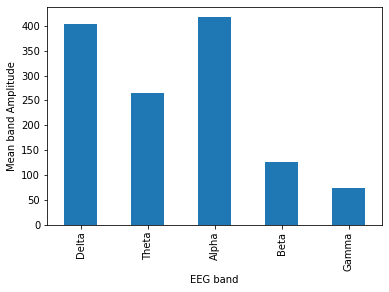

In [27]:
df = extract_band(dataset[1][0][1], 100)
ax = df.plot.bar(x='band', y='val', legend=False)
ax.set_xlabel("EEG band")
ax.set_ylabel("Mean band Amplitude")

In [28]:
dataset.x.shape

torch.Size([40030, 3, 3000])

In [48]:
class CustomSleepSpectrogramDataset(CustomSleepDataset):
    
    def __init__(self, file_list):
        super().__init__(file_list)
    def parse(self, sleep, hypnogram):
        _,_, header = highlevel.read_edf(hypnogram)
        signals, _, _ = highlevel.read_edf(sleep)
        for annotation in header['annotations']:
            start = int(annotation[0])
            end = int(annotation[1])
            sleep_stage = annotation[2][-1]
            if (sleep_stage != '?') and (sleep_stage !='W') and (sleep_stage != 'R') and (sleep_stage != 'e'):
                for i in range(start, start+end, 30):
                # pick i to i +30 for target range end
                    x = np.asarray([ signals[0][i*100:(i+30)*100],signals[1][i*100:(i+30)*100], signals[2][i*100:(i+30)*100]])
                    _,_,x = spectrogram(x, fs=100)
                    self.x.append(x)
                    self.y.append(labels[sleep_stage])

# dataset = 

sp_dataset= CustomSleepSpectrogramDataset(match_files("./sleep-cassette/"))

306


In [50]:
filename = '2d_sleeper_dataset.pkl'
outfile = open(filename,'wb')
pickle.dump(sp_dataset,outfile)
outfile.close()

In [52]:
len(sp_dataset)

40030

In [53]:
sp_dataset.x.shape

torch.Size([40030, 3, 129, 13])